# Exploring RNN architectures for Quantum state representation

A couple types of rnn:
    
    Gru
    
    Lstm
    
    2D lstm (if we have a 2d input)
    
    Tranformer (masked) (masked makes it causal whereas unmasked would be non causal)
    
Extra networks:

    Echo state networks  -> look into
    
    Resevoir computing cells -> look into
        
        Apparently you only train the output weights -> avoids a bunch of backprop
        
        but we use it in a recurrent fashion so you need to backprop still
        
        Look at BYOL for this (might not be possible)
    
    

# Quantum state to represent

- Start with Rydberg system

Transverse and longitudinal view of ising model

Excited state encourages nearby (within radius $R_b$)states to tend towards ground states

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math,time
import torch
from torch import nn
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
from numba import cuda

cuda:0


# Estimating the Rydberg Hamiltonian:

# $ \hat{H} = \frac{\Omega}{2}\sum_i{\hat{\sigma}_i^x} - \delta\sum_i\hat{n}_i+\sum_{i,j}V_{ij}\hat{n}_i\hat{n}_j$

# $ \hat{H} = \hat{H}_{off}+\hat{H}_{diag}  = \big[\frac{\Omega}{2}\sum_i{\hat{\sigma}_i^x} \big] + \big[ - \delta\sum_i\hat{n}_i+\sum_{i,j}V_{ij}\hat{n}_i\hat{n}_j \big]$


Here $\hat{n}_i = |r\rangle_i\langle r |_i = \left[\begin{array}{ccc}
1 & 0\\
0 & 0
\end{array}\right] $ acting only on $\sigma_i$ where $\left[\begin{array}{ccc}
1 \\
0
\end{array}\right]$ is an excited state


Hence $\hat{n}_i \hat{n}_j = |r\rangle_i\langle r |_i |r\rangle_j\langle r |_j = \left[\begin{array}{ccc}
1\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right] & 0\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right]\\
0\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right] & 0\left[\begin{array}{ccc}1 & 0\\0 & 0\end{array}\right]
\end{array}\right]  = \left[\begin{array}{ccc}
1 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 0
\end{array}\right]$  acting on $\sigma_i,\sigma_j$ where $\left[\begin{array}{ccc}
1 \left[\begin{array}{ccc}1 \\0\end{array}\right]\\
0 \left[\begin{array}{ccc}1 \\0\end{array}\right]
\end{array}\right] = \left[\begin{array}{ccc}
1 \\
0 \\
0 \\
0
\end{array}\right]$ is when $\sigma_i$ and $\sigma_j$ are both excited


Finally, $\hat{\sigma}_i^x = |g\rangle_i\langle r |_i + |r\rangle_i\langle g |_i = \left[\begin{array}{ccc}
0 & 1\\
1 & 0
\end{array}\right] $ is our off diagonal operator

# With $|\Psi_{\theta} \rangle = \sum_{\vec{\sigma}}\Psi_{\theta}(\vec{\sigma})|\sigma\rangle$

# $ \langle \Psi_{\theta}|\hat{H}_{diag}|\Psi_{\theta} \rangle = \big( \sum_{\sigma'} \langle\sigma'|\Psi^*_{\theta}(\vec{\sigma}')\big) \hat{H}_{diag} \big( \sum_{\sigma}\Psi_{\theta}(\vec{\sigma})|\sigma\rangle\big)$
$ = \sum_{\sigma',\sigma} \Psi^*_{\theta}(\vec{\sigma}')\Psi_{\theta}(\vec{\sigma}) \langle\sigma'| \hat{H}_{diag} |\sigma\rangle $

$ = \sum_{\sigma} P_\theta(\vec{\sigma}) \langle\sigma| \hat{H}_{diag} |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \langle\sigma| \hat{H}_{diag} |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \langle\sigma|\sum_{i,j}V_{ij}\hat{n}_i\hat{n}_j - \delta\sum_i\hat{n}_i |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \langle\sigma|\sum_{i}\hat{n}_i[(\sum_jV_{ij}\hat{n}_j) - \delta] |\sigma\rangle $

$ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \sum_{i}\sigma_i[(\sum_jV_{ij}\sigma_j) - \delta]$

 $ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \vec{\sigma}^T[V\vec{\sigma} - \delta (\vec{1})]$
 
# $ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta} \hat{H}^{diag}_{loc}(\vec{\sigma})$
# $\hat{H}^{diag}_{loc}(\vec{\sigma}) = \vec{\sigma}^T[V\vec{\sigma} - \delta (\vec{1})]$

# $ \langle \Psi_{\theta}|\hat{H}_{off}|\Psi_{\theta} \rangle = \big( \sum_{\sigma'} \langle\sigma'|\Psi^*_{\theta}(\vec{\sigma}')\big) \hat{H}_{off} \big( \sum_{\sigma}\Psi_{\theta}(\vec{\sigma})|\sigma\rangle\big)$
$ = \sum_{\sigma',\sigma} \Psi^*_{\theta}(\vec{\sigma}')\Psi_{\theta}(\vec{\sigma}) \langle\sigma'| \hat{H}_{off} |\sigma\rangle $

$ = \sum_{\sigma',\sigma} \frac{\Psi_{\theta}(\vec{\sigma})}{\Psi_{\theta}(\vec{\sigma})}\Psi^*_{\theta}(\vec{\sigma}')\Psi_{\theta}(\vec{\sigma}) \langle\sigma'| \hat{H}_{off} |\sigma\rangle $

$ = \sum_{\sigma',\sigma} \frac{\Psi^*_{\theta}(\vec{\sigma}')}{\Psi_{\theta}(\vec{\sigma})}|\Psi_{\theta}(\vec{\sigma})|^2 \langle\sigma'| \hat{H}_{off} |\sigma\rangle $

$ = \sum_{\sigma} |\Psi_{\theta}(\vec{\sigma})|^2 \sum_{\sigma'} \frac{\Psi^*_{\theta}(\vec{\sigma}')}{\Psi_{\theta}(\vec{\sigma})}\langle\sigma'| \hat{H}_{off} |\sigma\rangle $


$ = \sum_{\sigma} |\Psi_{\theta}(\vec{\sigma})|^2 \sum_{\sigma'} \frac{\Psi^*_{\theta}(\vec{\sigma}')}{\Psi_{\theta}(\vec{\sigma})}\langle\sigma'| \frac{\Omega}{2}\sum_i{\hat{\sigma}_i^x} |\sigma\rangle $

$ = \sum_{\sigma} |\Psi_{\theta}(\vec{\sigma})|^2 \frac{\Omega}{2}\sum_i\sum_{\sigma'} \frac{\Psi^*_{\theta}(\vec{\sigma}')}{\Psi_{\theta}(\vec{\sigma})}\langle\sigma'| {\hat{\sigma}_i^x} |\sigma\rangle $


$ = \sum_{\sigma} |\Psi_{\theta}(\vec{\sigma})|^2 \frac{\Omega}{2}\sum_i\sum_{\sigma'} \frac{\Psi^*_{\theta}(\vec{\sigma}')}{\Psi_{\theta}(\vec{\sigma})}\langle\sigma' |{\hat{\sigma}_i^x} (\sigma)\rangle $

$ = \sum_{\sigma} |\Psi_{\theta}(\vec{\sigma})|^2 \frac{\Omega}{2}\sum_i\frac{\Psi^*_{\theta}({\hat{\sigma}_i^x} (\vec{\sigma}))}{\Psi_{\theta}(\vec{\sigma})} $


$\approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta} \frac{\Omega}{2}\sum_i\frac{\Psi^*_{\theta}(\hat{\sigma}_i^x (\vec{\sigma}))}{\Psi_{\theta}(\vec{\sigma})} $

$\approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta} \frac{\Omega}{2\Psi_{\theta}(\vec{\sigma})}\sum_i\Psi^*_{\theta}(\hat{\sigma}_i^x (\vec{\sigma})) $

# $ \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta} \hat{H}^{off}_{loc}(\vec{\sigma})$

# $\hat{H}^{diag}_{loc}(\vec{\sigma}) = \frac{\Omega}{2\Psi_{\theta}(\vec{\sigma})}\sum_i{\Psi^*_{\theta}(\hat{\sigma}_i^x (\vec{\sigma}))} $

# $\hat{H}_{loc}(\vec\sigma) = \vec{\sigma}^T\big(V\vec{\sigma} - \delta (\vec{1})\big) + \frac{\Omega}{2\Psi_{\theta}(\vec{\sigma})}\sum_i{\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)} $


# So $ \langle \Psi_{\theta}|\hat{H}|\Psi_{\theta} \rangle \approx \frac{1}{N} \sum^N_{\sigma \sim P_\theta}  \big[ \vec{\sigma}^T\big(V\vec{\sigma} - \delta (\vec{1})\big) + \frac{\Omega}{2\Psi_{\theta}(\vec{\sigma})}\sum_i{\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)} \big ]$

In [2]:
class Hamiltonian():
    def __init__(self,L,offDiag,device=device):
        self.offDiag  = offDiag           # Off-diagonal interaction
        self.L        = L               # Number of spins
        self.device   = device
        self.Vij      = self.Vij=nn.Linear(self.L,self.L).to(device)
        self.buildlattice()
    def buildlattice():
        """Creates the matrix representation of the on-diagonal part of the hamiltonian
            - This should fill Vij with values"""
        raise NotImplementedError
    def localenergy(self,samples,logp,logppj):
        """
        Takes in s, ln[p(s)] and ln[p(s')] (for all s'), then computes Hloc(s) for N samples s.
        
        Inputs:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logp - size B vector of logscale probabilities ln[p(s)]
            logppj - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i][j] had one state flipped at position j
                    relative to s[i]
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B,device=self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        #logppj is shape [B,L]
        #logppj[:,j] has one state flipped at position j
        for j in range(self.L):
            #make sure torch.exp is a thing
            eloc += self.offDiag * torch.exp((logppj[:,j]-logp)/2)

        return eloc
    def localenergyALT(self,samples,logp,sumsqrtp,logsqrtp):
        """
        Takes in s, ln[p(s)] and exp(-logsqrtp)*sum(sqrt[p(s')]), then computes Hloc(s) for N samples s.
        
        Inputs:
            samples  - [B,L,1] matrix of zeros and ones for ground/excited states
            logp     - size B vector of logscale probabilities ln[p(s)]
            logsqrtp - size B vector of average (log p)/2 values used for numerical stability 
                       when calculating sum_s'(sqrt[p(s')/p(s)]) 
            sumsqrtp - size B vector of exp(-logsqrtp)*sum(sqrt[p(s')]).
        Returns:
            size B vector of energies Hloc(s)
        
        """
        # Going to calculate Eloc for each sample in a separate spot
        # so eloc will have shape [B]
        # recall samples has shape [B,L,1]
        B=samples.shape[0]
        eloc = torch.zeros(B,device=self.device)
        # Chemical potential
        with torch.no_grad():
            tmp=self.Vij(samples.squeeze(2))
            eloc += torch.sum(tmp*samples.squeeze(2),axis=1)
        # Off-diagonal part
        
        #in this function the entire sum is precomputed and it was premultiplied by exp(-logsqrtp) for stability
        eloc += self.offDiag *sumsqrtp* torch.exp(logsqrtp-logp/2)

        return eloc
    def ground(self):
        """Returns the ground state energy E/L"""
        raise NotImplementedError

In [3]:
help(Hamiltonian)

Help on class Hamiltonian in module __main__:

class Hamiltonian(builtins.object)
 |  Hamiltonian(L, offDiag, device=device(type='cuda', index=0))
 |  
 |  Methods defined here:
 |  
 |  __init__(self, L, offDiag, device=device(type='cuda', index=0))
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  buildlattice()
 |      Creates the matrix representation of the on-diagonal part of the hamiltonian
 |      - This should fill Vij with values
 |  
 |  ground(self)
 |      Returns the ground state energy E/L
 |  
 |  localenergy(self, samples, logp, logppj)
 |      Takes in s, ln[p(s)] and ln[p(s')] (for all s'), then computes Hloc(s) for N samples s.
 |      
 |      Inputs:
 |          samples - [B,L,1] matrix of zeros and ones for ground/excited states
 |          logp - size B vector of logscale probabilities ln[p(s)]
 |          logppj - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i][j] had one state flipped at position j
 |                 

In [4]:
@cuda.jit
def Vij(Ly,Lx,Rcutoff,V,matrix):
    #matrix will be size [Lx*Ly,Lx*Ly]
    
    i,j=cuda.grid(2)
    if i>Ly or j>Lx:
        return
    R=Rcutoff**6
    #flatten two indices into one
    idx = Ly*j+i
    # only fill in the upper diagonal
    for k in range(idx+1,Lx*Ly):
        #expand one index into two
        i2 = k%Ly
        j2=k//Ly
        div = ((i2-i)**2+(j2-j)**2)**3
        if div<=R:
            matrix[idx][k]=V/div

class Rydberg(Hamiltonian):
    E={16:-0.45776822,36:-0.4221,64:-0.40522,144:-0.38852,256:-0.38052,576:-0.3724,1024:-0.3687}
    def __init__(self,Lx,Ly,V,Omega,delta,R=2.01,device=device):
        self.Lx       = Lx              # Size along x
        self.Ly       = Ly              # Size along y
        self.V        = V               # Van der Waals potential
        self.delta    = delta           # Detuning
        self.R=R
        # off diagonal part is -0.5*Omega
        super(Rydberg,self).__init__(Lx*Ly,-0.5*Omega,device)
        
    def buildlattice(self):
        Lx,Ly=self.Lx,self.Ly
        
        #diagonal hamiltonian portion can be written as a matrix multiplication then a dot product        
        mat=np.zeros([self.L,self.L])
        
        Vij[(1,1),(Lx,Ly)](Lx,Ly,self.R,self.V,mat)
        with torch.no_grad():
            self.Vij.weight[:,:]=torch.Tensor(mat)
            self.Vij.bias.fill_(-self.delta)
    def ground(self):
        return Rydberg.E[self.Lx*self.Ly]

# Transverse Field Ising Model

# $H = - J\sum_i S_z^iS_z^{i+1}+h\sum_iS_x^i$

In [5]:
class TFIM(Hamiltonian):
    En1={40:-1.2642,500:-1.2725,100:-1.2696 ,1000:-1.2729}
    def __init__(self,L,h_x,J=1.0,device=device):
        self.J = J
        super(TFIM,self).__init__(L,h_x,device)
        
    def buildlattice(self):
        #building hamiltonian matrix for diagonal part
        mat=np.zeros([self.L,self.L])
        for i in range(self.L - 1):
            mat[i, i+1] = -self.J

        with torch.no_grad():
            self.Vij.weight[:,:]=torch.Tensor(mat)
            self.Vij.bias.fill_(0.0) # no longitudinal field

    def localenergy(self,samples,logp,logppj):
        return super(TFIM,self).localenergyALT(2*samples-1,logp,logppj)

    def localenergyALT(self,samples,logp,sumsqrtp,logsqrtp):
        return super(TFIM,self).localenergyALT(2*samples-1,logp,sumsqrtp,logsqrtp)
    def ground(self):
        if self.J==1 and self.offDiag==-1:
            if self.L in TFIM.En1:
                return TFIM.En1[self.L]
        return -10

# Samples & Labelling to get $\langle \Psi_{\theta}|\hat{H}|\Psi_{\theta} \rangle$:

# $P_{\theta}(\vec{\sigma}) = |\Psi_{\theta}(\vec{\sigma})|^2  = \Pi_{i=1}^{L} P_{\theta}(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)$ 

where $P_{\theta}(\sigma_i|. . .)$ is your network

Log probabilities: $ln(P_{\theta}(\vec{\sigma})) = 2\cdot ln(\Psi_{\theta}(\vec{\sigma}))  = \sum_{i=1}^{L} ln( P_{\theta}(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1))$


 For sampling we can just draw each (individual atom) state $\sigma_i$ from $P_{\theta}(\sigma_i|\sigma_{i-1},\sigma_{i-2} . . . \sigma_1)$ to construct $\vec{\sigma}$


# I require any sampler to implement:

#      - sample(Batch,Length)

Generate {$\vec{\sigma}^{_0},\vec{\sigma}^{_1}, . . . \vec{\sigma}^{_B}$} where $\vec\sigma^{_k} = [\sigma^{_k}_1,\sigma^{_k}_2, . . . \sigma^{_k}_L]$

#      - logprobability(input)

With input {$\vec{\sigma}^{_0},\vec{\sigma}^{_1}, . . . \vec{\sigma}^{_B}$}, give me {$ln(P(\vec{\sigma}^{_0})),ln(P(\vec{\sigma}^{_1})), . . . ln(P(\vec{\sigma}^{_B}))$}

In [6]:
class Sampler(nn.Module):
    def __init__(self,device=device):
        self.device=device
        super(Sampler, self).__init__()
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        raise NotImplementedError
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        raise NotImplementedError
    
    @torch.jit.ignore
    def sample_with_labels(self,B,L,grad=False,nloops=1):
        """Inputs:
            B (int) - The number of states to generate in parallel
            L (int) - The length of generated vectors
            grad (boolean) - Whether or not to use gradients
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
            logppl - [B,L] matrix of logscale probabilities ln[p(s')] where s'[i+B*j] had one spin flipped at position j
                    relative to s[i]
        """
        sample=self.sample(B,L)
        return self._off_diag_labels(sample,B,L,grad,nloops)
    
    
    @torch.jit.ignore
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        """label all of the flipped states faster (no loop in rnn) but using more ram"""
        sflip = torch.zeros([B,L,L,1],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:,j] = sample*1.0
            sflip[:,j,j] = 1-sflip[:,j,j]
        #compute all of their logscale probabilities
        if not grad:
            with torch.no_grad():
                probs=torch.zeros([B*L],device=self.device)
                tmp=sflip.view([B*L,L,1])
                for k in range(D):
                    probs[k*B*L//D:(k+1)*B*L//D] = self.logprobability(tmp[k*B*L//D:(k+1)*B*L//D])
        else:
            probs = self.logprobability(sflip.view([B*L,L,1]))

        return sample,probs.reshape([B,L])
    
    @torch.jit.ignore
    def sample_with_labelsALT(self,B,L,grad=False,nloops=1):
        """Returns:
            samples  - [B,L,1] matrix of zeros and ones for ground/excited states
            logsqrtp - size B vector of average (log p)/2 values used for numerical stability 
                       when calculating sum_s'(sqrt[p(s')/p(s)]) 
            sumsqrtp - size B vector of exp(-logsqrtp)*sum(sqrt[p(s')]).
        """
        sample,probs = self.sample_with_labels(B,L,grad,nloops)
        #get the average of our logprobabilities and divide by 2
        logsqrtp=probs.mean(dim=1)/2
        #compute the sum with a constant multiplied to keep the sum closeish to 1
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    
    

In [7]:
import pydoc

#help function prints too much stuff so I'm getting the info and removing the unimportant bits
documentation = pydoc.text.document(Sampler, "").split("--------")[0]
out= documentation.split("Base class for all neural network modules")[0]+documentation.split("builtins.object")[1]
toprint,i=out[0],1
while i<len(out):toprint+= out[i] if (out[i]!= "\x08" and out[i-1] != "\x08") else "";i+=1
print(toprint)

class Sampler(torch.nn.modules.module.Module)
 |  Sampler(device=device(type='cuda', index=0))
 |  
 |  
 |  
 |  Methods defined here:
 |  
 |  __init__(self, device=device(type='cuda', index=0))
 |      Initializes internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  logprobability(self, input)
 |      Compute the logscale probability of a given state
 |      Inputs:
 |          input - [B,L,1] matrix of zeros and ones for ground/excited states
 |      Returns:
 |          logp - [B] size vector of logscale probability labels
 |  
 |  sample(self, B, L)
 |      Generates a set states
 |      Inputs:
 |          B (int)            - The number of states to generate in parallel
 |          L (int)            - The length of generated vectors
 |      Returns:
 |          samples - [B,L,1] matrix of zeros and ones for ground/excited states
 |  
 |  sample_with_labels(self, B, L, grad=False, nloops=1)
 |      Inputs:
 |          B (int) - The number of states to gene

# Simple RNN to start


In [8]:
class RNN(Sampler):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    def __init__(self,rnntype="GRU",Nh=128,device=device, **kwargs):
        super(RNN, self).__init__(device=device)
        #rnn takes input shape [B,L,1]
        self.rnn = RNN.TYPES[rnntype](input_size=1,hidden_size=Nh,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(128,128),
                nn.ReLU(),
                nn.Linear(128,1),
                nn.Sigmoid()
            )
        
        self.rnntype=rnntype
        self.to(device)
    def forward(self, input):
        # h0 is shape [d*numlayers,B,H] but D=numlayers=1 so
        # h0 has shape [1,B,H]
        
        if self.rnntype=="LSTM":
            h0=[torch.zeros([1,input.shape[0],128],device=self.device),
               torch.zeros([1,input.shape[0],128],device=self.device)]
            #h0 and c0
        else:
            h0=torch.zeros([1,input.shape[0],128],device=self.device)
        out,h=self.rnn(input,h0)
        return self.lin(out)
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you multiply your conditional probability by pred[i]
        #if real[i]=0 than you multiply by 1-pred[i]
        
        #probability predictions may be done WITH gradients
        #with torch.no_grad():
        
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        if self.rnntype=="LSTM":
            h=[torch.zeros([1,B,128],device=self.device),
               torch.zeros([1,B,128],device=self.device)]
            #h is h0 and c0
        else:
            h=torch.zeros([1,B,128],device=self.device)
        #Sample set will have shape [N,L,1]
        #need one extra zero batch at the start for first pred hence input is [N,L+1,1] 
        input = torch.zeros([B,L+1,1],device=self.device)
        #sampling can be done without gradients
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]
            
            out,h=self.rnn(input[:,idx-1:idx,:],h)
            out=out[:,0,:]
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(out)
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[:,idx,:]=sample
        #input's first entry is zero to get a predction for the first atom
        return input[:,1:,:]

In [9]:
testrnn = RNN()
testrnn.sample_with_labelsALT
print(testrnn.rnntype)
x=torch.zeros([10,4*4,1]).to(device)
print(testrnn(x).shape)
print(testrnn.logprobability(x).shape)
sample = testrnn.sample(10,4*4)
print(sample.shape)

GRU
torch.Size([10, 16, 1])
torch.Size([10])
torch.Size([10, 16, 1])


In [10]:
def new_rnn_with_optim(rnntype,Nh,lr=1e-3,beta1=0.9,beta2=0.999):
    rnn = RNN(rnntype=rnntype,Nh=Nh)
    optimizer = torch.optim.Adam(
    rnn.parameters(), 
    lr=lr, 
    betas=(beta1,beta2)
    )
    return rnn,optimizer

trainrnn,optimizer=new_rnn_with_optim("GRU",128,lr=1e-3)

# Massive Speedup idea:

$ \langle \Psi_{\theta}|\hat{H}|\Psi_{\theta} \rangle \approx \frac{1}{B} \sum^B_{\sigma \sim P_\theta}  \big[ \vec{\sigma}^T\big(V\vec{\sigma} - \delta (\vec{1})\big) + \frac{\Omega}{2\Psi_{\theta}(\vec{\sigma})}\sum_i{\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)} \big ]$ is very expensive to evaluate because you have to compute $\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)$ L times  per each sample $\vec\sigma$ (Note: $L = L_x \cdot L_y$) is the dimension of $\vec\sigma$

Since $\Psi(\sigma) \in O(\sigma) = O(L)$, we have $\hat H_{loc}{(\sigma)} \in O(L^2)$, so our computation will scale quadratically with out number of atoms.

Total computation time is then $O(B\cdot L^2)$ with B=N is our batch/sample size

Since getting $\sum_i{\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)}$ is our slowest step, what if we just saved samples $\sigma$ into a queue along with the value of $\sum_i{\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)}$. Say we push K $\bigg\{\sigma , \sum_i{\Psi^*_{\theta}\big(\hat{\sigma}_i^x (\vec{\sigma})\big)}\bigg\}$ pairs into our queue on each training iteration (and deque K pairs to maintain queue size). Note: we would still have to generate new values of $P_{\theta_t}(\sigma)$ to get $\langle H_t \rangle$ and packpropogate to update $\theta_{t+1} \leftarrow ADAM(\theta_{t},\partial_{\theta}\langle H \rangle)$. (This should be $O(BL)$)

Execution will then be $O(KL^2+BL)$. Setting $K = C\cdot\frac{B}{L}$ (where C is const) would give $O(BL)$ time but for this to work you would need $CB \gt L$ which gives an inherent limit on the size of L, with K=1, B=L you would be generating one sample per iteration, but evaluating on a batch of size L essentially for free.

# Downsides and workarounds

With a queue, labels for $\sum_i{\Psi^*\big(\hat{\sigma}_i^x (\vec{\sigma})\big)}$ and samples $\sigma$ are reated with $\Psi_{\theta_{t-j}}$ where  $j \in [1,\frac{B}{K}]$ instead of $\Psi_{\theta_{t}}$ (so $\sigma \sim P_{\theta_{t-j}}$)

This means you are updating your gradients with out of date samples as well as slightly wrong off-diagonal hamiltonian values.

If these differences are too big, you can get results like the one below:

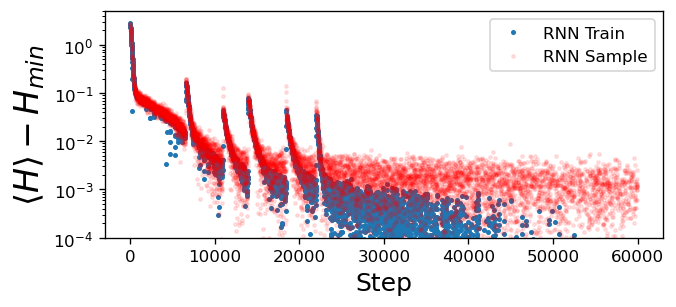

Here the gradient descent algorithm is overfitting to the old sample distribution (and perhaps off-diagonal energies) every once and a while and losing a bunch of progress in the process.


The current workaround is to have a separate rnn for sampling and training / labelling. The sampling rnn changes slowly and without gradients, and the training rnn changes faster and with gradients.

Denoting the sampler as $P_{\Theta_t}$ and trainer as $P_{\theta_t}$, in one iteration we take:

$\theta_{t+1} \leftarrow ADAM(\theta_{t},\partial_{\theta_t}\langle H \rangle)$

$\Theta_{t+1} \leftarrow m\Theta_t + (1-m)\theta_{t+1}$

Here $m \in [0,1)$ is our momentum and the higher it is, the slower $P_{\Theta}$ changes

Also, if training $P_{\theta}$ gets 'too' far away from sampling $P_{\Theta}$ (which I can detect), I decided to just set

$\theta_{t+1} \leftarrow \Theta_t$

$\Theta_{t+1} \leftarrow \Theta_t$




In [11]:
def momentum_update(m, target_network, network):
    for target_param, param in zip(target_network.parameters(), network.parameters()):
        target_param.data.copy_(target_param.data*m + param.data*(1.0-m))

In [12]:
samplernn = RNN(rnntype="GRU",Nh=128)

for target_param in samplernn.parameters():
    target_param.data.copy_(target_param.data*5)

with torch.no_grad():
    print(trainrnn(torch.zeros([1,4,1],device=device))[0,:,0])
    print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])
        
for x in range(100):
    with torch.no_grad():
        momentum_update(0.90,samplernn,trainrnn)
        if x%10==0:
            print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])
momentum_update(0.0,samplernn,trainrnn)

with torch.no_grad():
    print(trainrnn(torch.zeros([1,4,1],device=device))[0,:,0])
    print(samplernn(torch.zeros([1,4,1],device=device))[0,:,0])

tensor([0.4910, 0.4916, 0.4920, 0.4923], device='cuda:0')
tensor([0.7114, 0.7652, 0.8146, 0.8257], device='cuda:0')
tensor([0.6795, 0.7273, 0.7620, 0.7906], device='cuda:0')
tensor([0.5414, 0.5428, 0.5436, 0.5439], device='cuda:0')
tensor([0.5055, 0.5062, 0.5066, 0.5069], device='cuda:0')
tensor([0.4948, 0.4954, 0.4960, 0.4964], device='cuda:0')
tensor([0.4921, 0.4928, 0.4933, 0.4936], device='cuda:0')
tensor([0.4914, 0.4920, 0.4924, 0.4927], device='cuda:0')
tensor([0.4911, 0.4918, 0.4921, 0.4924], device='cuda:0')
tensor([0.4910, 0.4917, 0.4920, 0.4923], device='cuda:0')
tensor([0.4910, 0.4916, 0.4920, 0.4923], device='cuda:0')
tensor([0.4910, 0.4916, 0.4920, 0.4923], device='cuda:0')
tensor([0.4910, 0.4916, 0.4920, 0.4923], device='cuda:0')
tensor([0.4910, 0.4916, 0.4920, 0.4923], device='cuda:0')


# Setting Constants

In [13]:
class Opt:
    """
    Description of these options:
    
    L (int) -- Total lattice size (np.prod(lattice.shape))
    Q  (int) -- Number of minibatches in the queue
    K  (int) -- size of each minibatch
    B  (int) -- Total batch size (should be Q*K)
    TOL (float) -- Tolerance to decide if train energies are too good to be true
    M (float)   -- Momentum used for sample RNN update
    USEQUEUE (bool)-- If False, the entire queue is updated with samples from the sample rnn at each step
    NLOOPS (int)   -- This saves ram at the cost of more runtime.
    hamiltonian (string) -- Which hamiltonian to train on
    steps (int) -- Number of training steps
    """
    DEFAULTS={'L':16,'Q':32,'K':16,'B':32*16,'TOL':0.15,'M':31/32,'USEQUEUE':True,'NLOOPS':1,
              "hamiltonian":"Rydberg","steps": 12000}
    def __init__(self,**kwargs):
        self.__dict__.update(Opt.DEFAULTS)
        self.__dict__.update(kwargs)

    def __str__(self):
        out=""
        for key in self.__dict__:
            line=key+" "*(30-len(key))+ "\t"*3+str(self.__dict__[key])
            out+=line+"\n"
        return out
    
    def apply(self,args):
        kwargs = dict()
        for arg in args:
            try:
                key,val=arg.split("=")
                kwargs[key]=self.sus_cast(val)
            except:pass
        self.__dict__.update(kwargs)
    def sus_cast(self,x0):
        try:
            x=x0
            x=float(x0)
            x=int(x0)
        except:return x
        return x

In [14]:
op=Opt()
op.apply(["steps=4000","hamiltonian=TFIM","L=40","J=1.0","h=-1.0"])
print(op)

L                             			40
Q                             			32
K                             			16
B                             			512
TOL                           			0.15
M                             			0.96875
USEQUEUE                      			True
NLOOPS                        			1
hamiltonian                   			TFIM
steps                         			4000
J                             			1.0
h                             			-1.0



In [15]:
# Hamiltonian parameters
N = op.L   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

if op.hamiltonian=="Rydberg":
    Lx=Ly=int(op.L**0.5)
    op.L=Lx*Ly
    h = Rydberg(Lx,Ly,V,Omega,delta)
else:
    h = TFIM(op.L,op.h,op.J)

exact_energy = h.ground()
print(exact_energy,op.L)


-1.2642 40


# Training with Memory Queue


# Queue Algorithm:




>$q_{t\sigma} \leftarrow \{\vec\sigma^1,\vec\sigma^2 . . \vec\sigma^K\}$ where $\sigma \sim P_{\Theta_t}$<br />
>$q_{P_{\Theta_t}} \leftarrow \sum_i{\Psi^*_{\Theta_t}\big(\hat{\sigma}_i^x (q_{t\sigma})\big)}$<br />
>$p_{\Theta_t} \leftarrow P_{\Theta_t} (q_\sigma)$ (no gradients)<br />
Enqueue $\big[ q_{t\sigma} , q_{P_{\Theta_t}}\big]$ <br />
>Dequeue $\big[ q_{{(t-n)}\sigma} , q_{P_{\Theta_{t-n}}}\big]$ where $n=\frac{B}{K}$<br />
> * Our queue $Q$ can be broken up into two parts:<br />
> * $Q_\sigma = \{\vec\sigma^1,\vec\sigma^2. . . \vec\sigma^B\}$, $Q_{P_{\Theta}} = \bigg\{\sum_i{\Psi^*_{\Theta_{t-1}}\big(\hat{\sigma}_i^x (\vec\sigma^{1})\big),. . .\sum_i{\Psi^*_{\Theta_{t-\frac{B}{K}+1}}\big(\hat{\sigma}_i^x (\vec\sigma^B)\big)}\big]\bigg\}}$<br />
>
>$P_{\theta} \leftarrow P_{\theta_t}(Q_{\sigma})$ (with gradients)<br />
>$E \leftarrow \big[ Q_{\sigma}^T\big(VQ_{\sigma} - \delta (\vec{1})\big) + \frac{\Omega}{2P_{\theta}}Q_{P_{\Theta}} \big ]$ (no gradients)<br />
>Loss $\leftarrow \big(E-\langle E \rangle\big)ln(P_{\theta})$<br />
>$E_{\Theta_t}  \leftarrow \langle \big[ q_{t\sigma}^T\big(Vq_{t\sigma} - \delta (\vec{1})\big) + \frac{\Omega}{2p_{\Theta_t}}q_{P_{\Theta_t}} \big ] \rangle$ (no gradients)<br />
>IF $ min(E_{\Theta_t},E_{\Theta_{t-1}} . . . E_{\Theta_{t-n}}) -E > TOL: $<br />
>> $\theta_{t+1} \leftarrow \Theta_t$<br />
>> $\Theta_{t+1} \leftarrow \Theta_t$<br />
>
>ELSE:
>> $\theta_{t+1} \leftarrow ADAM(\theta_{t},\partial_{\theta_t}\langle Loss \rangle)$<br />
>> $\Theta_{t+1} \leftarrow m\Theta_t + (1-m)\theta_{t+1}$<br />
>
>ENDIF


# Energy Corrections

# Say we sample from $P_\Theta(\vec{\sigma})$ instead of $P_\theta(\vec{\sigma})$



# $\sum_{\sigma} P_\theta(\vec{\sigma}) \langle\sigma| \hat{H}_{diag} |\sigma\rangle  = \sum_{\sigma} \frac{P_\Theta(\vec{\sigma})}{P_\Theta(\vec{\sigma})} P_\theta(\vec{\sigma}) \langle\sigma| \hat{H}_{diag} |\sigma\rangle $
# $ = \frac{1}{N}\sum^N_{\sigma \sim P_\Theta} \frac{P_\theta(\vec{\sigma})}{P_\Theta(\vec{\sigma})}  \langle\sigma| \hat{H}_{diag} |\sigma\rangle $

In [16]:
debug=[]
losses=[]
true_energies=[]

In [17]:



samplequeue = torch.zeros([op.B,op.L,1],device=device)
sump_queue=torch.zeros([op.B],device=device)
sqrtp_queue=torch.zeros([op.B],device=device)
Eo_queue = torch.zeros([op.Q],device=device)
lp_queue = torch.zeros([op.B],device=device)


def fill_queue():
    global sample,simp,sqrtp,E_i,lp
    for i in range(op.Q):
        sample,sump,sqrtp = samplernn.sample_with_labelsALT(op.K,op.L,grad=False,nloops=op.NLOOPS)
        with torch.no_grad():
            #create and store true values for energy
            lp=samplernn.logprobability(sample)
            E_i=h.localenergyALT(sample,lp,sump,sqrtp)
            Eo_queue[i]=E_i.mean()/(op.L)
            samplequeue[i*op.K:(i+1)*op.K]=sample
            sump_queue[i*op.K:(i+1)*op.K]=sump
            sqrtp_queue[i*op.K:(i+1)*op.K]=sqrtp
            lp_queue[i*op.K:(i+1)*op.K] = lp

fill_queue()
print(Eo_queue.mean().item())
            
if not op.USEQUEUE:
    nqueue_updates = op.Q
else:
    nqueue_updates=1


i=0
t=time.time()
for x in range(op.steps):
    
    for k in range(nqueue_updates):
        sample,sump,sqrtp = samplernn.sample_with_labelsALT(op.K,op.L,grad=False,nloops=op.NLOOPS)
        
        with torch.no_grad():
            #create and store true values for energy
            lp=samplernn.logprobability(sample)
            E_i=h.localenergyALT(sample,lp,sump,sqrtp)
            Eo_queue[i]=E_i.mean()/(op.L)
            samplequeue[i*op.K:(i+1)*op.K]=sample
            sump_queue[i*op.K:(i+1)*op.K]=sump
            sqrtp_queue[i*op.K:(i+1)*op.K]=sqrtp
            lp_queue[i*op.K:(i+1)*op.K] = lp
        i=(i+1)%op.Q
    
    logp=trainrnn.logprobability(samplequeue)
    
    with torch.no_grad():
        E=h.localenergyALT(samplequeue,logp,sump_queue,sqrtp_queue)
        
        #energy mean and variance
        Ev,Eo=torch.var_mean(E)
        
    
    #energy correction mean and variance
    CEv,CEo = torch.var_mean(E*torch.exp(logp-lp_queue))
    
    ERR  = Eo/(op.L)
    
    loss = (E*logp - Eo*logp).mean()
    
    
    
    #Main loss curve to follow
    losses.append(ERR.cpu().item())
               

    #if Energy sees an unrealistic improvement
    #ignore this at early stages
    f=0
    if x>2000 and Eo_queue.min()-losses[-1]>op.TOL:
        #backprop the loss because it may clear temp arrays
        loss.backward()
        #zero my gradients
        trainrnn.zero_grad()
        #update momentum and comtinue
        with torch.no_grad():
            #set both rnns to the same thing then fill the queue
            #momentum_update(0.0,samplernn,trainrnn)
            
            #set it back to the slow moving sample rnn??
            momentum_update(0.0,trainrnn,samplernn)
            #refill the queue to get accurate probabilities
            #fill_queue()
            f=1
            #print("",end="<%.3f|%d>"%(Eo_queue.mean().item(),x))
    else:
        trainrnn.zero_grad()
        loss.backward()
        optimizer.step()
        #do your regular momentum update
        momentum_update(op.M,samplernn,trainrnn)
            
    debug+=[[Ev.item()**0.5,Eo.item(),CEv.item()**0.5,CEo.item(),loss.item(),E_i.mean().item(),f,time.time()-t]]
    
    if x%500==0:
        print(int(time.time()-t),end=",%.2f|"%(losses[-1]))
print(time.time()-t,x+1)

-1.0017986297607422
0,-1.00|10,-1.23|20,-1.26|30,-1.26|40,-1.26|50,-1.26|60,-1.26|70,-1.26|80.25759172439575 4000


In [18]:
DEBUG = np.array(debug)

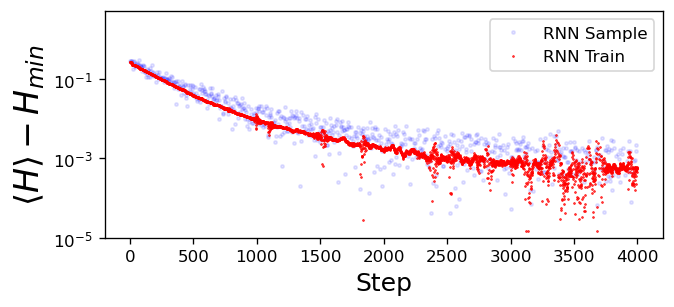

In [19]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(DEBUG[:,5]/op.L-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
plt.plot(DEBUG[:,1]/op.L-exact_energy,'ro',ms=0.5,lw=0.0,label="RNN Train")
plt.yscale("log")
plt.ylim(1e-5,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.show()

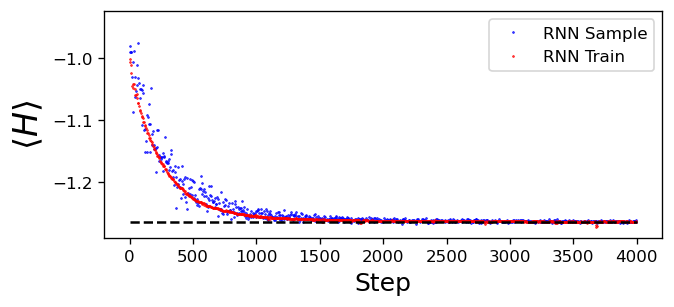

In [28]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(DEBUG[:,5]/op.L,'bo',markersize=0.5,linewidth=0.0,markevery=5,label="RNN Sample")
plt.plot(DEBUG[:,1]/op.L,'ro',markersize=0.5,linewidth=0.0,markevery=5,label="RNN Train")
plt.plot([0,len(losses)],[exact_energy,exact_energy],'k--')
#plt.ylim(max(min(losses)-0.3,-2),0.5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")
plt.show()

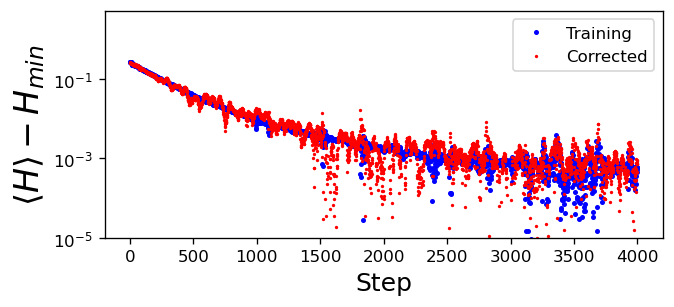

In [21]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(DEBUG[:,1]/op.L-exact_energy,'bo',ms=2,label="Training")
plt.plot(DEBUG[:,3]/op.L-exact_energy,'ro',ms=1,label="Corrected")
plt.yscale("log")
plt.ylim(1e-5,5)
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.show()

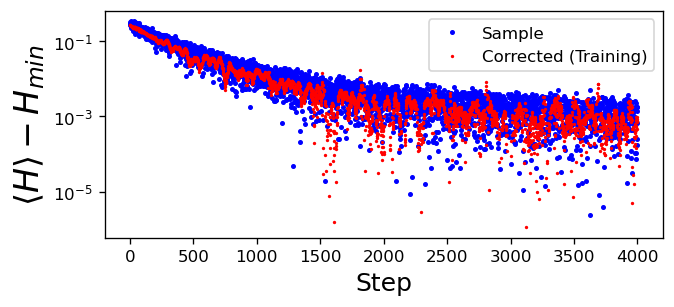

In [22]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(DEBUG[:,5]/op.L-exact_energy,'bo',ms=2,label="Sample")
plt.plot(DEBUG[:,3]/op.L-exact_energy,'ro',ms=1,lw=1,label="Corrected (Training)")
plt.yscale("log")
plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
plt.legend(loc="best")
plt.show()

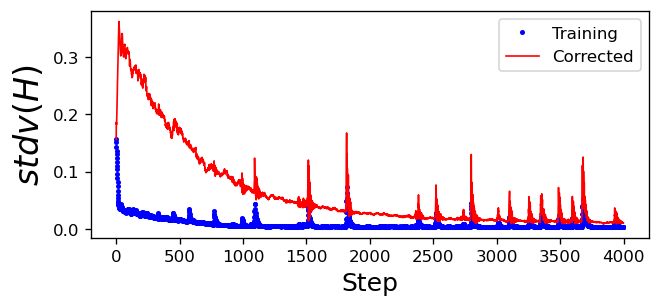

In [23]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
plt.plot(DEBUG[:,0]/op.L,'bo',ms=2,label="Training")
plt.plot(DEBUG[:,2]/op.L,'r-',lw=1,label="Corrected")
plt.ylabel("$stdv(H)$",fontsize=20)
plt.xlabel("Step",fontsize=15)
plt.legend(loc="best")
plt.show()

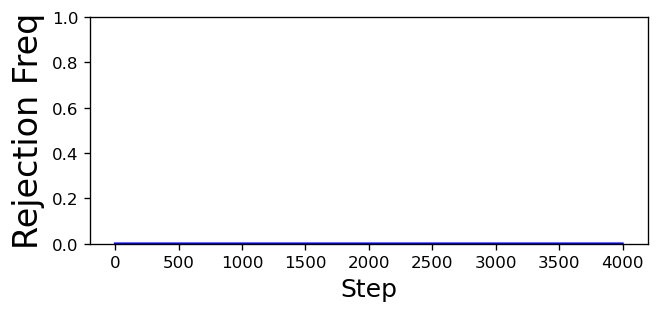

0.0


In [24]:
fig = plt.figure(1,figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')
avgs = np.array([np.mean(DEBUG[i:i+100,-2]) for i in range(DEBUG.shape[0])])
plt.plot(avgs,'b-')
plt.ylim(0,1)
plt.xlabel("Step",fontsize=15)
plt.ylabel("Rejection Freq",fontsize=20)
plt.show()
print(np.sum(DEBUG[:,6]))

In [25]:
def errplt(out,*args,**kwargs):
    """Plots with nice error bars"""
    fmt=None
    args = [a for a in args]
    for i in range(len(args)):
        if type(args[i])==type(str()):fmt=args[i];del args[i]
    if len(args)<2:in_=np.arange(out.shape[0])
    if len(args)==1:errs=args[0]
    if len(args)==2:in_,out,errs=out,args[0],args[1]
    if len(args)>0:        
        if fmt!= None:
            plt.plot(in_,out,fmt,**kwargs)
            c=fmt[0]
            plt.fill_between(in_,out-errs,out+errs,color=c,alpha=0.4)
        else:
            plt.plot(in_,out,**kwargs)
            plt.fill_between(in_,out-errs,out+errs)

In [26]:
1/0

ZeroDivisionError: division by zero

In [ ]:
import os

mydir="out/%dx%d-M=%.3f-B=%d-K=%d"%(op.Lx,op.Ly,op.M,op.B,op.K)

try:
    os.mkdir(mydir)
except:pass
if True:
    print(DEBUG[-1][3]/Lx/Ly-exact_energy,DEBUG[-1][3]/Lx/Ly,DEBUG[-1][1]/Lx/Ly,exact_energy)
    torch.save(trainrnn,mydir+"/T")
    torch.save(samplernn,mydir+"/S")
    np.save(mydir+"/DEBUG",DEBUG)

In [ ]:
if False:
    trainrnn=torch.load("TSTB")
    arrs = np.load("TSTB.npz")
    losses,true_energies = [arrs[a] for a in arrs]

In [ ]:
if False:
    bsize=512
    BlockNum=32
    BbyL=bsize//BlockNum

    SQ = torch.zeros([bsize*10,Lx*Ly,1]).to(device)
    SPQ=torch.zeros([bsize*10]).to(device)
    SRPQ=torch.zeros([bsize*10]).to(device)


    for k in range(BlockNum*10):
        sample,sump,sqrtp = trainrnn.sample_with_labelsALT(BbyL,Lx*Ly,grad=False)
        with torch.no_grad():
            SQ[k*BbyL:(k+1)*BbyL]=sample
            SPQ[k*BbyL:(k+1)*BbyL]=sump
            SRPQ[k*BbyL:(k+1)*BbyL]=sqrtp

    with torch.no_grad():
        logp=trainrnn.logprobability(SQ)
        E=h.localenergyALT(SQ,logp,SPQ,SRPQ)
        Eo=E.mean()

    ERR  = Eo/(Lx*Ly)

    print(ERR.detach().item())
    print(torch.var_mean(E/(Lx*Ly)))
    print(exact_energy)

# Save and Push

In [ ]:
import IPython
IPython.display.display(IPython.display.Javascript("IPython.notebook.save_notebook()"),include=['application/javascript'])

In [ ]:
1/0

In [ ]:
import os
os.system("git commit -a -m \"Auto Commit\"")
os.system("git push origin")

In [ ]:
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
x=torch.zeros(10)
x.min().item()

# TODO: 

- Investigate why using corrected energies makes the gradients explode
- Implement 2D rnn if I have time
- Run a bunch of tests with / without queue at different sizes